# AirBnB Listing Analysis
## Analyze AirBnB listings in Paris to determine the impact of recent regulations

### OBJECTIVES
As AirBnB has grown in popularity, it has increasingly become the focus of
regulations designed to limit the number of properties listed in each city.
You've been asked to analyze Paris listings, with a focus on pricing. Leadership
wants a visual summary of factors affecting pricing and whether regulations
adopted in 2015 impacted listings in the Paris Market

1. Explore and profile the data to correct any quality issues
2. Prepare and reformat the data for visualization
3. Visualize the data and identify key insights and recommendations

In [2]:
# Imports
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

# Pandas settings
pd.set_option("display.max_columns", None)

## Load and review the data

In [4]:
# Read in the data limit the number of columns to the fields of interest
listings = pd.read_csv("data/Listings.csv",
                       usecols=["host_since", "neighbourhood", "city", "accommodates", "price"],
                       parse_dates=["host_since"],
                       low_memory=False,
                       encoding="iso-8859-1")

# Filter down to included only Paris listings
listings = listings.loc[listings["city"] == "Paris", :]

# Optimize data types (not strictly necessary here but done anyway for practice).
listings = listings.astype({"neighbourhood": "category", "city": "category", "accommodates": "Int8", "price": "Int16"})
listings.head()

,host_since,neighbourhood,city,accommodates,price
0,2011-12-03,Buttes-Montmartre,Paris,2,53
1,2013-11-29,Buttes-Montmartre,Paris,2,120
2,2014-07-31,Elysee,Paris,2,89
3,2013-12-17,Vaugirard,Paris,2,58
4,2014-12-14,Passy,Paris,2,60


In [5]:
listings.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
Index: 64690 entries, 0 to 279711
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   host_since     64657 non-null  datetime64[ns]
 1   neighbourhood  64690 non-null  category      
 2   city           64690 non-null  category      
 3   accommodates   64690 non-null  Int8          
 4   price          64690 non-null  Int16         
dtypes: Int16(1), Int8(1), category(2), datetime64[ns](1)
memory usage: 1.4 MB


## Check for missing values

In [7]:
(listings.isna().sum() / listings.shape[0]).round(4) * 100 # divide by total rows and multipy by 100 to get the percent of missing values

host_since       0.05
neighbourhood    0.00
city             0.00
accommodates     0.00
price            0.00
dtype: float64

Given that missing values are only present in one column and represent only a fraction of a percent, we will proceed without further data manipulation.

## Quick EDA

In [10]:
listings.loc[:, "city"].value_counts() # Confirms only Paris listings are present in the dataset

city
Paris    64690
Name: count, dtype: int64

In [11]:
listings.loc[:, "neighbourhood"].value_counts()

neighbourhood
Buttes-Montmartre      7237
Popincourt             6206
Vaugirard              4826
Enclos-St-Laurent      4628
Batignolles-Monceau    4330
Menilmontant           3758
Buttes-Chaumont        3728
Passy                  3215
Opera                  3157
Temple                 2943
Reuilly                2654
Observatoire           2485
Gobelins               2278
Bourse                 2188
Pantheon               2140
Luxembourg             1998
Hotel-de-Ville         1972
Palais-Bourbon         1771
Elysee                 1768
Louvre                 1408
Name: count, dtype: int64

In [12]:
listings.loc[:, ["accommodates", "price"]].describe().round()

,accommodates,price
count,64690.0,64690.0
mean,3.0,113.0
std,2.0,214.0
min,0.0,0.0
25%,2.0,59.0
50%,2.0,80.0
75%,4.0,120.0
max,16.0,12000.0


Dig into the zero minimums for price and accommodates

In [14]:
# Number of listings with only 0 accomdations
listings.loc[listings["accommodates"] == 0, "accommodates"].count()

54

In [15]:
# Number of listings renting out for free
listings.loc[listings["price"] == 0, "price"].count()

62

As with the missing host data, these anomalies represent such a small proportion of the data that no manipulations or drops will be made. However, zero accommodations will be removed from the Paris accommodations chart below as they add nothing to the analysis and just take up space.

## Prepare the data for visualization

In [18]:
paris_listings_neighbourhood = (
    listings
    .groupby("neighbourhood", observed=False)
    .agg(mean_price=("price", "mean"))
    .sort_values("mean_price", ascending=True)
)

paris_listings_neighbourhood

,mean_price
neighbourhood,
Menilmontant,74.942257
Buttes-Chaumont,82.690182
Buttes-Montmartre,87.209479
Reuilly,89.058402
Popincourt,90.559459
Gobelins,98.110184
Observatoire,101.866801
Batignolles-Monceau,102.612702
Enclos-St-Laurent,102.967156


In [19]:
paris_listings_accomodations = (
    listings
    .query("neighbourhood == 'Elysee'")
    .groupby("accommodates")
    .agg(mean_price=("price", "mean"))
    .sort_values("mean_price", ascending=True)
)

paris_listings_accomodations

,mean_price
accommodates,
0,0.0
1,79.522222
3,152.828767
2,155.103352
4,212.09607
5,328.817073
6,355.508571
8,405.518519
7,411.538462


In [20]:
paris_listings_over_time = (
    listings
    .groupby(listings["host_since"].dt.year)
    .agg(new_hosts=("host_since", "count"),
         mean_price=("price", "mean"))
)

paris_listings_over_time

,new_hosts,mean_price
host_since,,
2008.0,4,77.75
2009.0,106,159.641509
2010.0,416,125.03125
2011.0,1339,124.82823
2012.0,4592,111.578615
2013.0,8142,107.096414
2014.0,10922,100.2538
2015.0,12147,103.64625
2016.0,8871,114.159847


## Create the requested visualizations

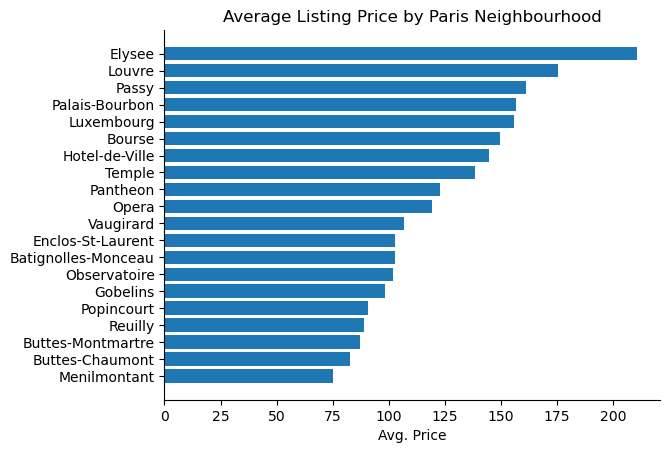

In [22]:
fig, ax = plt.subplots()

ax.barh(paris_listings_neighbourhood.index,
       paris_listings_neighbourhood["mean_price"])

ax.set_title("Average Listing Price by Paris Neighbourhood")
ax.set_xlabel("Avg. Price")

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.show()

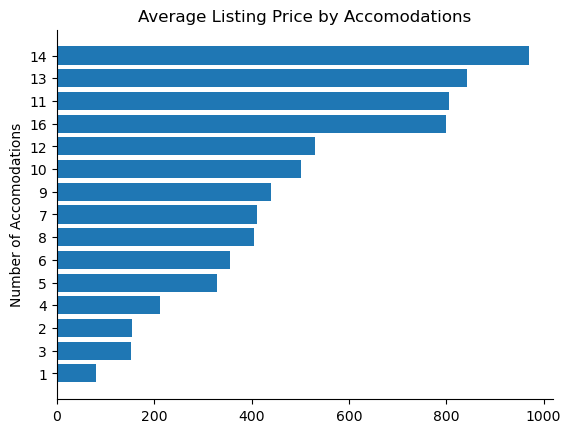

In [23]:
# Remove the zero accomdations records as discussed above
paris_listings_accomodations_sans_zero = paris_listings_accomodations.loc[1:,]

fig, ax = plt.subplots()

ax.barh(paris_listings_accomodations_sans_zero.index.astype("string"),
       paris_listings_accomodations_sans_zero["mean_price"])
ax.set_title("Average Listing Price by Accomodations")
ax.set_ylabel("Number of Accomodations")

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.show()

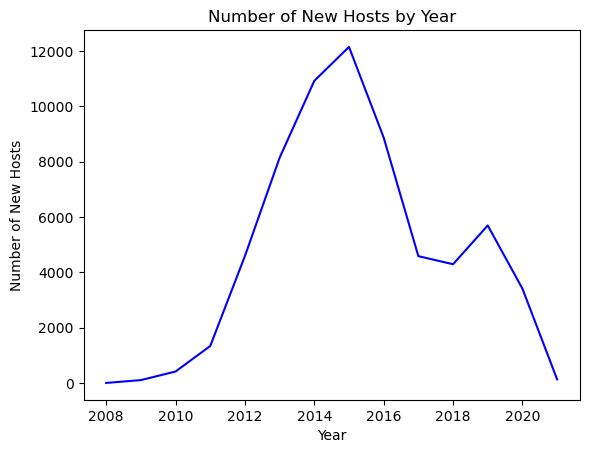

In [24]:
fig, ax = plt.subplots()

ax.plot(paris_listings_over_time.index,
        paris_listings_over_time.loc[:,"new_hosts"],
        color="blue")

ax.set_title("Number of New Hosts by Year")
ax.set_xlabel("Year")
ax.set_ylabel("Number of New Hosts")

plt.show()

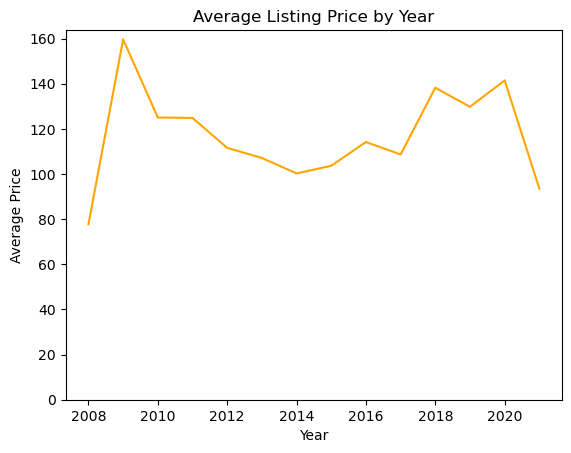

In [25]:
fig, ax = plt.subplots()

ax.plot(paris_listings_over_time.index,
        paris_listings_over_time.loc[:, "mean_price"],
        color="orange")

ax.set_title("Average Listing Price by Year")
ax.set_xlabel("Year")
ax.set_ylabel("Average Price")
ax.set_ylim(0)

plt.show()

It appears that, generally, as the number of new hosts increases, average prices drop, and when the number of new hosts decreases, average prices rise. Combining these two graphs into one will make this clearer.

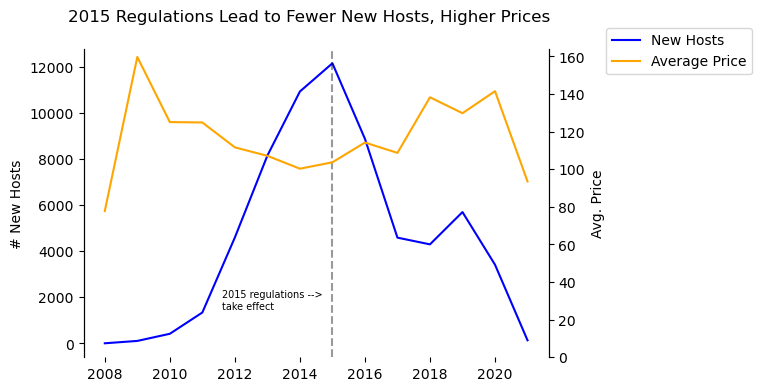

In [27]:
fig, ax = plt.subplots(figsize=(6, 4))

ax.plot(paris_listings_over_time.index,
       paris_listings_over_time.loc[:,"new_hosts"],
       label="New Hosts",
       color="blue")

ax.set_ylabel("# New Hosts")

ax.axvline(2015, color="black", ls="--", alpha=0.4)

ax.text(2011.6, 1500, "2015 regulations -->\ntake effect", fontsize=7)

ax.spines["top"].set_visible(False)
ax.spines["bottom"].set_visible(False)

ax2 = ax.twinx()

ax2.plot(paris_listings_over_time.index,
        paris_listings_over_time.loc[:,"mean_price"],
        label="Average Price",
        color="orange")
ax2.set_ylabel("Avg. Price")
ax2.set_ylim(0)

ax2.spines["top"].set_visible(False)
ax2.spines["bottom"].set_visible(False)

fig.suptitle("2015 Regulations Lead to Fewer New Hosts, Higher Prices")
fig.legend(bbox_to_anchor=(1.25, 0.95))
plt.show()

## Conclusion:
### The impact of the 2015 regulations on new hosts and prices
 
The new regulations seem to have led to a substantial drop in new hosts per year. Subsequently, this led to a slower but steady rise in average prices. This is consistent with basic supply and demand as the lower supply predicts prices should rise, assuming all other factors are held equal. Of course, this analysis does not attempt to hold other things equal (control for other relevant variables).

However, the observations are consistent with basic supply and demand theory, and it cannot be ruled out that the 2015 regulations led to an overall increase in average Paris listing prices.